# Imports

In [59]:
import os
from shutil import copyfile
from __future__ import division, print_function
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import soundfile as sf
import numpy as np
import random
import cv2
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.image as mpimg

# Converting Recordings to spectograms

In [2]:
def wav_to_spectrogram(audio_path, save_path, spectrogram_dimensions=(64, 64), noverlap=16):
    """ Creates a spectrogram of a wav file.

    :param audio_path: path of wav file
    :param save_path:  path of spectrogram to save
    :param spectrogram_dimensions: number of pixels the spectrogram should be. Defaults (64,64)
    :param noverlap: See http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    :return:
    """

    sample_rate, samples = wav.read(audio_path)

    fig = plt.figure()
    fig.set_size_inches((spectrogram_dimensions[0]/fig.get_dpi(), spectrogram_dimensions[1]/fig.get_dpi()))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.specgram(samples, Fs=2, noverlap=noverlap)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(save_path, bbox_inches="tight", pad_inches=0)


def dir_to_spectrogram(audio_dir, spectrogram_dir, spectrogram_dimensions=(64, 64), noverlap=16):
    """ Creates spectrograms of all the audio files in a dir

    :param audio_dir: path of directory with audio files
    :param spectrogram_dir: path to save spectrograms
    :param spectrogram_dimensions: tuple specifying the dimensions in pixes of the created spectrogram. default:(64,64)
    :param noverlap: See http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    :return:
    """
    file_names = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f)) and '.wav' in f]

    for file_name in file_names:
        print(file_name)
        audio_path = audio_dir + file_name
        spectogram_path = spectrogram_dir + file_name.replace('.wav', '.png')
        wav_to_spectrogram(audio_path, spectogram_path, spectrogram_dimensions=spectrogram_dimensions, noverlap=noverlap)

In [ ]:
audio_dir = "./recordings/"
spectrogram_dir = "./No_Augmentation/spectrograms/"
dir_to_spectrogram(audio_dir, spectrogram_dir)

In [ ]:
# List of image filenames
filenames = [
    "0_george_5.png",
    "1_george_5.png",
    "2_george_5.png",
    "3_george_5.png"
]

# Create a subplot with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, filename in zip(axes, filenames):
    # Read the image from the current directory (change path if needed)
    img = mpimg.imread(os.path.join("./No_Augmentation/spectrograms/", filename))
    ax.imshow(img)
    ax.axis('off')
    
    # Extract the digit (first number in the filename)
    digit = filename.split('_')[0]
    
    # Set the title under the image
    ax.set_title(f"Digit: {digit}", fontsize=12)

plt.tight_layout()
plt.show()

# Separating Dataset into Training and Testing Datasets

In [4]:
def separate(source, output):
    for filename in os.listdir(source):
        first_split = filename.rsplit("_", 1)[1]
        second_split = first_split.rsplit(".", 1)[0]
        if int(second_split) <= 4:
            copyfile(source + "/" + filename, output + "/test" + "/" + filename)
        else:
            copyfile(source + "/" + filename, output + "/train" + "/" + filename)

In [5]:
separate("./No_Augmentation/spectrograms", "./No_Augmentation")

# Speech augmentation

- To Apply Speech Augmentation:
    - Create a function that applies the required Speech augmentaion
    - Apply this function on the no augmentation records
    - After the augmented records are created, convert them into spectorgrams splitted into training and testing data

In [12]:
speed_up_rate = 1.05
slow_down_rate = 0.95
noise_probability = 0.5
noise_level = 0.005

def speech_augmentation(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'):
            copyfile(input_dir + "/" + filename, output_dir + "/" + filename)
            filepath = os.path.join(input_dir, filename)
            
            # Load the audio file (keeping the native sampling rate)
            y, sr = librosa.load(filepath, sr=None)
            D = librosa.stft(y, n_fft=512)
            
            # Augmentation 1: Speed up 5%
            D_stretched = librosa.phase_vocoder(D, rate=speed_up_rate)
            y_fast = librosa.istft(D_stretched)
            fast_filename = f"{os.path.splitext(filename)[0]}_fast.wav"
            sf.write(os.path.join(output_dir, fast_filename), y_fast, sr)
            
            # Augmentation 2: Slow down 5%
            D_stretched = librosa.phase_vocoder(D, rate=slow_down_rate)
            y_slow = librosa.istft(D_stretched)
            slow_filename = f"{os.path.splitext(filename)[0]}_slow.wav"
            sf.write(os.path.join(output_dir, slow_filename), y_slow, sr)
            
            # Augmentation 3: Optionally add noise to the original audio
            if random.random() < noise_probability:
                # Compute a random noise amplitude relative to the audio's maximum amplitude
                noise_amp = noise_level * np.random.uniform() * np.max(np.abs(y))
                noise = noise_amp * np.random.normal(size=y.shape)
                y_noise = y + noise
                noise_filename = f"{os.path.splitext(filename)[0]}_noise.wav"
                sf.write(os.path.join(output_dir, noise_filename), y_noise, sr)

In [7]:
separate("./recordings", "./Speech_Augmentation/recordings")

In [13]:
input_dir = "./Speech_Augmentation/recordings/train"
output_dir = "./Speech_Augmentation/augmented_recordings/train"
speech_augmentation(input_dir, output_dir)
input_dir = "./Speech_Augmentation/recordings/test"
output_dir = "./Speech_Augmentation/augmented_recordings/test"
speech_augmentation(input_dir, output_dir)

In [15]:
filepath = "./Speech_Augmentation/augmented_recordings/train/0_george_5.wav"
y, sr = librosa.load(filepath, sr=None)
orig_duration = len(y) / sr
print(f"Original duration of {orig_duration:.3f} seconds")

# After speeding up:
filepath = "./Speech_Augmentation/augmented_recordings/train/0_george_5_fast.wav"
y_fast, sr = librosa.load(filepath, sr=None)
fast_duration = len(y_fast) / sr
print(f"Fast version duration of {fast_duration:.3f} seconds")

# After slowing down:
filepath = "./Speech_Augmentation/augmented_recordings/train/0_george_5_slow.wav"
y_slow, sr = librosa.load(filepath, sr=None)
slow_duration = len(y_slow) / sr
print(f"Slow version duration of {slow_duration:.3f} seconds")


Original duration of 0.643 seconds
Fast version duration of 0.624 seconds
Slow version duration of 0.688 seconds


In [ ]:
audio_dir = "./Speech_Augmentation/augmented_recordings/train/"
spectrogram_dir = "./Speech_Augmentation/train/"
dir_to_spectrogram(audio_dir, spectrogram_dir)
audio_dir = "./Speech_Augmentation/augmented_recordings/test/"
spectrogram_dir = "./Speech_Augmentation/test/"
dir_to_spectrogram(audio_dir, spectrogram_dir)

# Spectrum Augmentation

- To Apply Specturm Augmentation:
    - Create a function that applies the required Spectrum augmentaion
    - Apply this function on the spectum images generated from the no augmentation records (Found in No_Augmentation directory)

In [20]:
def augment_spectrum_images(input_dir, output_dir,
                            noise_probability=0.5, noise_level=0.05):
    """
    Augment spectrum images by horizontally squeezing (5% smaller width),
    expanding (5% larger width), and optionally adding noise.

    Parameters:
    - input_dir: Directory containing original images.
    - output_dir: Directory where augmented images will be saved.
    - noise_probability: Fraction of images to add noise to.
    - noise_level: Standard deviation factor for Gaussian noise (relative to 255).
    """
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each image file in the input directory
    filenames = os.listdir(input_dir)
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            copyfile(input_dir + "/" + filename, output_dir + "/" + filename)
            filepath = os.path.join(input_dir, filename)
            img = cv2.imread(filepath)
            if img is None:
                continue  # Skip files that can't be read

            height, width, channels = img.shape

            # -------------------------
            # Augmentation 1: Squeeze Horizontally (reduce width by 5%)
            # -------------------------
            new_width_squeeze = int(width * 0.95)
            squeezed = cv2.resize(img, (new_width_squeeze, height),
                                  interpolation=cv2.INTER_LINEAR)
            # To maintain the original dimensions, pad horizontally.
            pad_left = (width - new_width_squeeze) // 2
            pad_right = width - new_width_squeeze - pad_left
            squeezed_padded = cv2.copyMakeBorder(squeezed, 0, 0, pad_left, pad_right,
                                                 borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
            squeezed_filename = os.path.splitext(filename)[0] + '_squeezed.png'
            cv2.imwrite(os.path.join(output_dir, squeezed_filename), squeezed_padded)

            # -------------------------
            # Augmentation 2: Expand Horizontally (increase width by 5%)
            # -------------------------
            new_width_expand = int(width * 1.05)
            expanded = cv2.resize(img, (new_width_expand, height),
                                  interpolation=cv2.INTER_LINEAR)
            # Crop back to the original width (center crop)
            crop_left = (new_width_expand - width) // 2
            expanded_cropped = expanded[:, crop_left:crop_left+width]
            expanded_filename = os.path.splitext(filename)[0] + '_expanded.png'
            cv2.imwrite(os.path.join(output_dir, expanded_filename), expanded_cropped)

            # -------------------------
            # Augmentation 3: Add Noise
            # -------------------------
            if random.random() < noise_probability:
                # Generate Gaussian noise and add it to the image.
                # noise_level is relative to the max pixel value (255).
                noise = np.random.normal(0, noise_level * 255, img.shape).astype(np.float32)
                noisy_img = img.astype(np.float32) + noise
                noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
                noisy_filename = os.path.splitext(filename)[0] + '_noisy.png'
                cv2.imwrite(os.path.join(output_dir, noisy_filename), noisy_img)

In [21]:
input_dir = "./No_Augmentation/train"
output_dir = "./Spectrum_augmentation/train"
augment_spectrum_images(input_dir, output_dir)
input_dir = "./No_Augmentation/test"
output_dir = "./Spectrum_augmentation/test"
augment_spectrum_images(input_dir, output_dir)

# Speech and Spectrum Augmentation

- To Apply Speech and Specturm Augmentation:
    - Apply the spectrum function on the spectum images generated from the augmented records generated in the speech augmentation part (Found in Speech_Augmentation directory)

In [24]:
input_dir = "./Speech_Augmentation/train/"
output_dir = "./Spectrum_Speech_augmentation/train"
augment_spectrum_images(input_dir, output_dir)
input_dir = "./Speech_Augmentation/test/"
output_dir = "./Spectrum_Speech_augmentation/test"
augment_spectrum_images(input_dir, output_dir)

# Lenet Model

In [25]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Conv1: 6 filters, 5x5, 'same' padding (padding=2 for kernel_size=5)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # AvgPool1: 2x2, stride=2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Conv2: 16 filters, 5x5, 'valid' padding (padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        # AvgPool2: 2x2, stride=2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # After the convolution and pooling layers:
        # Input image: 28x28 -> after conv1+pool1: 14x14 -> after conv2+pool2: 5x5 (with 16 filters)
        # Flatten: 16 * 5 * 5 = 400
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # Output layer: 10 classes; no softmax needed when using CrossEntropyLoss
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Logits are returned; softmax is applied in the loss function (nn.CrossEntropyLoss)
        return x

In [27]:
class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        """
        directory: Path to the directory containing images.
        transform: Optional torchvision transforms to apply.
        """
        self.directory = directory
        self.transform = transform
        # List image file paths (supports .png, .jpg, .jpeg)
        self.files = [os.path.join(directory, f) for f in os.listdir(directory)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        # Open image and convert to grayscale (LeNet expects 1 channel)
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        else:
            # Default transform: resize to 28x28 and convert to tensor
            default_transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.ToTensor()
            ])
            image = default_transform(image)
        
        # Extract the label from the filename using regex (e.g., "0_george_5.png")
        filename = os.path.basename(img_path)
        label_match = re.match(r'(\d+)', filename)
        if label_match:
            label = int(label_match.group(1))
        else:
            raise ValueError(f"Filename {filename} does not start with a numeric label.")
        
        return image, label


In [34]:
batch_size = 16
num_epochs = 30
learning_rate = 0.001

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [37]:
def train_and_evaluate(model, train_loader, test_loader, device,
                       num_epochs=30, learning_rate=0.001):
    """
    Trains and evaluates the given model using the provided train and test loaders.
    
    Parameters:
      - model: The neural network model to be trained.
      - train_loader: DataLoader for the training data.
      - test_loader: DataLoader for the testing/validation data.
      - device: The torch device (cpu or cuda) to perform training.
      - num_epochs: Number of training epochs.
      - learning_rate: Learning rate for the optimizer.
      
    Returns:
      - model: The trained model.
      - train_acc_list: List of training accuracies per epoch.
      - test_acc_list: List of testing accuracies per epoch.
    """
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_acc_list = []
    test_acc_list = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
            # Compute training accuracy on-the-fly
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_acc_list.append(train_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        
        # Evaluation on test data
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
        test_accuracy = 100 * correct_test / total_test
        test_acc_list.append(test_accuracy)
        print(f"Test Acc: {test_accuracy:.2f}%")
    
    print("Training complete.")
    return model, train_acc_list, test_acc_list

In [38]:
def plot_accuracies(train_acc, test_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, test_acc, 'ro-', label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Part A

In [39]:
# Directories for training and testing
train_dir = "./No_Augmentation/train/"
test_dir = "./No_Augmentation/test/"

# Define transforms (resizing to 28x28 and converting to tensor)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize from 64x64 to 28x28
    transforms.ToTensor()
])

# Create datasets
train_dataset = CustomDataset(train_dir, transform=transform)
test_dataset  = CustomDataset(test_dir, transform=transform)

# Create data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [40]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
trained_model, train_accuracies, test_accuracies = train_and_evaluate(model, train_loader, test_loader, device)

Epoch 1/30, Loss: 2.1817, Train Acc: 17.70%
Test Acc: 38.00%
Epoch 2/30, Loss: 1.2943, Train Acc: 50.19%
Test Acc: 66.67%
Epoch 3/30, Loss: 0.8812, Train Acc: 66.30%
Test Acc: 74.67%
Epoch 4/30, Loss: 0.7313, Train Acc: 73.37%
Test Acc: 73.33%
Epoch 5/30, Loss: 0.6077, Train Acc: 77.67%
Test Acc: 79.00%
Epoch 6/30, Loss: 0.5123, Train Acc: 81.56%
Test Acc: 73.33%
Epoch 7/30, Loss: 0.4350, Train Acc: 85.44%
Test Acc: 89.33%
Epoch 8/30, Loss: 0.3732, Train Acc: 88.00%
Test Acc: 87.00%
Epoch 9/30, Loss: 0.3226, Train Acc: 90.04%
Test Acc: 89.67%
Epoch 10/30, Loss: 0.2889, Train Acc: 90.48%
Test Acc: 89.67%
Epoch 11/30, Loss: 0.2546, Train Acc: 91.81%
Test Acc: 92.33%
Epoch 12/30, Loss: 0.2196, Train Acc: 92.67%
Test Acc: 89.00%
Epoch 13/30, Loss: 0.1975, Train Acc: 93.26%
Test Acc: 92.67%
Epoch 14/30, Loss: 0.1760, Train Acc: 94.41%
Test Acc: 93.00%
Epoch 15/30, Loss: 0.1528, Train Acc: 95.15%
Test Acc: 94.33%
Epoch 16/30, Loss: 0.1498, Train Acc: 94.89%
Test Acc: 92.00%
Epoch 17/30, Loss

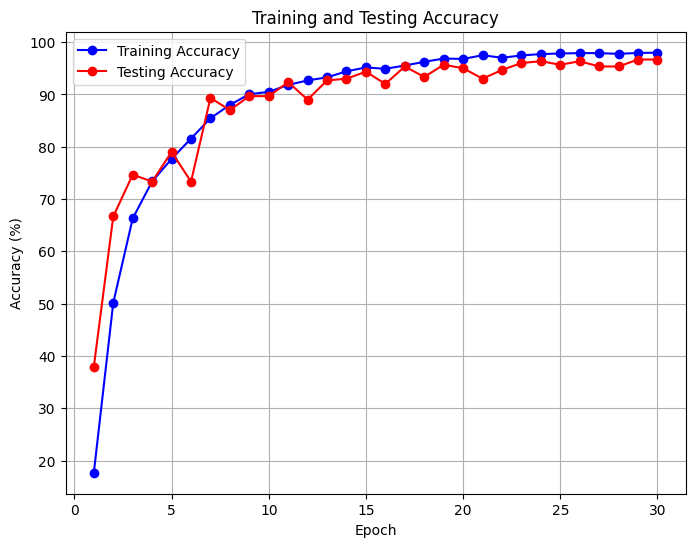

In [42]:
plot_accuracies(train_accuracies, test_accuracies)

# Part B

In [43]:
# Directories for training and testing
train_dir = "./Speech_Augmentation/train/"
test_dir = "./Speech_Augmentation/test/"

# Define transforms (resizing to 28x28 and converting to tensor)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize from 64x64 to 28x28
    transforms.ToTensor()
])

# Create datasets
train_dataset = CustomDataset(train_dir, transform=transform)
test_dataset  = CustomDataset(test_dir, transform=transform)

# Create data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [44]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
trained_model, train_accuracies, test_accuracies = train_and_evaluate(model, train_loader, test_loader, device)

Epoch 1/30, Loss: 1.2685, Train Acc: 52.85%
Test Acc: 74.29%
Epoch 2/30, Loss: 0.5652, Train Acc: 80.07%
Test Acc: 87.15%
Epoch 3/30, Loss: 0.3659, Train Acc: 87.57%
Test Acc: 87.15%
Epoch 4/30, Loss: 0.2569, Train Acc: 91.21%
Test Acc: 93.10%
Epoch 5/30, Loss: 0.1720, Train Acc: 94.56%
Test Acc: 94.42%
Epoch 6/30, Loss: 0.1311, Train Acc: 95.80%
Test Acc: 94.99%
Epoch 7/30, Loss: 0.1029, Train Acc: 96.63%
Test Acc: 94.80%
Epoch 8/30, Loss: 0.0892, Train Acc: 97.16%
Test Acc: 96.22%
Epoch 9/30, Loss: 0.0726, Train Acc: 97.58%
Test Acc: 96.98%
Epoch 10/30, Loss: 0.0609, Train Acc: 97.90%
Test Acc: 96.50%
Epoch 11/30, Loss: 0.0528, Train Acc: 98.20%
Test Acc: 97.64%
Epoch 12/30, Loss: 0.0471, Train Acc: 98.45%
Test Acc: 97.07%
Epoch 13/30, Loss: 0.0398, Train Acc: 98.79%
Test Acc: 96.12%
Epoch 14/30, Loss: 0.0329, Train Acc: 98.97%
Test Acc: 96.50%
Epoch 15/30, Loss: 0.0317, Train Acc: 98.92%
Test Acc: 96.12%
Epoch 16/30, Loss: 0.0347, Train Acc: 98.80%
Test Acc: 96.98%
Epoch 17/30, Loss

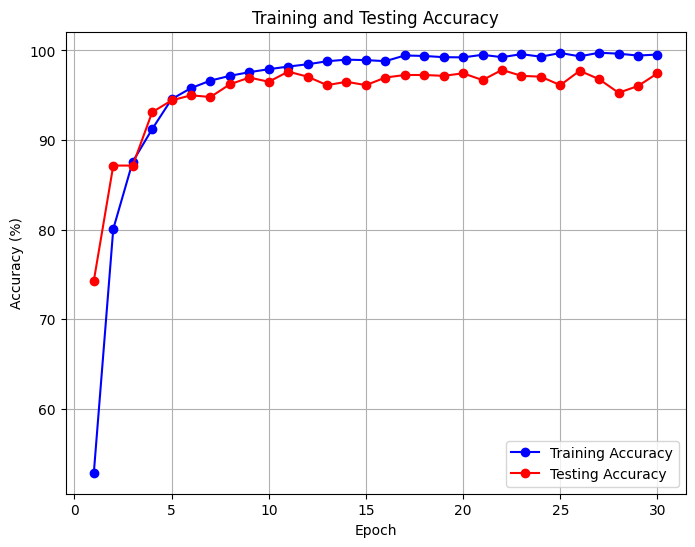

In [46]:
plot_accuracies(train_accuracies, test_accuracies)

# Part C

In [48]:
# Directories for training and testing
train_dir = "./Spectrum_augmentation/train/"
test_dir = "./Spectrum_augmentation/test/"

# Define transforms (resizing to 28x28 and converting to tensor)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize from 64x64 to 28x28
    transforms.ToTensor()
])

# Create datasets
train_dataset = CustomDataset(train_dir, transform=transform)
test_dataset  = CustomDataset(test_dir, transform=transform)

# Create data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [49]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
trained_model, train_accuracies, test_accuracies = train_and_evaluate(model, train_loader, test_loader, device)

Epoch 1/30, Loss: 1.4477, Train Acc: 44.21%
Test Acc: 67.18%
Epoch 2/30, Loss: 0.6487, Train Acc: 76.13%
Test Acc: 80.77%
Epoch 3/30, Loss: 0.3911, Train Acc: 86.63%
Test Acc: 89.86%
Epoch 4/30, Loss: 0.2625, Train Acc: 91.37%
Test Acc: 92.06%
Epoch 5/30, Loss: 0.1859, Train Acc: 93.58%
Test Acc: 94.93%
Epoch 6/30, Loss: 0.1424, Train Acc: 95.39%
Test Acc: 93.59%
Epoch 7/30, Loss: 0.1081, Train Acc: 96.44%
Test Acc: 94.64%
Epoch 8/30, Loss: 0.0823, Train Acc: 97.24%
Test Acc: 93.97%
Epoch 9/30, Loss: 0.0667, Train Acc: 97.89%
Test Acc: 96.36%
Epoch 10/30, Loss: 0.0513, Train Acc: 98.38%
Test Acc: 96.17%
Epoch 11/30, Loss: 0.0504, Train Acc: 98.31%
Test Acc: 95.89%
Epoch 12/30, Loss: 0.0342, Train Acc: 98.91%
Test Acc: 95.22%
Epoch 13/30, Loss: 0.0320, Train Acc: 98.91%
Test Acc: 96.84%
Epoch 14/30, Loss: 0.0302, Train Acc: 98.97%
Test Acc: 94.07%
Epoch 15/30, Loss: 0.0248, Train Acc: 99.20%
Test Acc: 96.08%
Epoch 16/30, Loss: 0.0221, Train Acc: 99.35%
Test Acc: 95.60%
Epoch 17/30, Loss

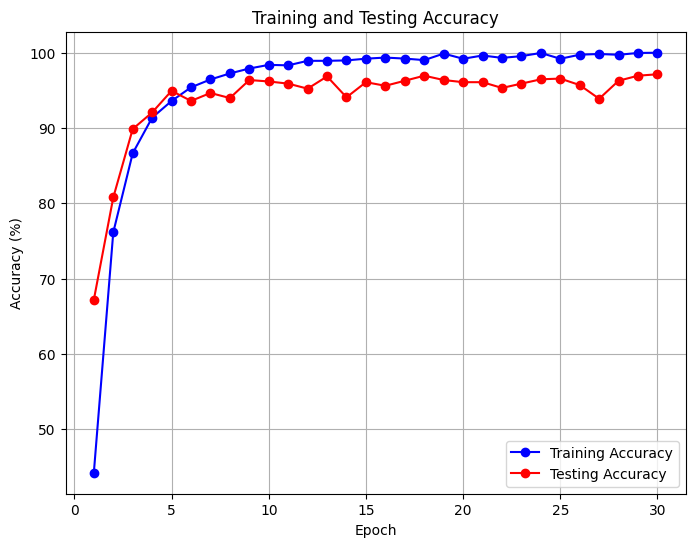

In [51]:
plot_accuracies(train_accuracies, test_accuracies)

# Part D

In [54]:
# Directories for training and testing
train_dir = "./Spectrum_Speech_augmentation/train/"
test_dir = "./Spectrum_Speech_augmentation/test/"

# Define transforms (resizing to 28x28 and converting to tensor)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize from 64x64 to 28x28
    transforms.ToTensor()
])

# Create datasets
train_dataset = CustomDataset(train_dir, transform=transform)
test_dataset  = CustomDataset(test_dir, transform=transform)

# Create data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [55]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
trained_model, train_accuracies, test_accuracies = train_and_evaluate(model, train_loader, test_loader, device)

Epoch 1/30, Loss: 0.7976, Train Acc: 70.65%
Test Acc: 85.20%
Epoch 2/30, Loss: 0.1986, Train Acc: 93.32%
Test Acc: 96.16%
Epoch 3/30, Loss: 0.0975, Train Acc: 96.94%
Test Acc: 95.92%
Epoch 4/30, Loss: 0.0620, Train Acc: 97.91%
Test Acc: 96.02%
Epoch 5/30, Loss: 0.0429, Train Acc: 98.54%
Test Acc: 97.10%
Epoch 6/30, Loss: 0.0293, Train Acc: 99.10%
Test Acc: 94.47%
Epoch 7/30, Loss: 0.0223, Train Acc: 99.28%
Test Acc: 96.13%
Epoch 8/30, Loss: 0.0177, Train Acc: 99.42%
Test Acc: 96.21%
Epoch 9/30, Loss: 0.0169, Train Acc: 99.45%
Test Acc: 97.15%
Epoch 10/30, Loss: 0.0143, Train Acc: 99.58%
Test Acc: 96.96%
Epoch 11/30, Loss: 0.0106, Train Acc: 99.62%
Test Acc: 97.05%
Epoch 12/30, Loss: 0.0113, Train Acc: 99.67%
Test Acc: 97.23%
Epoch 13/30, Loss: 0.0110, Train Acc: 99.64%
Test Acc: 96.64%
Epoch 14/30, Loss: 0.0076, Train Acc: 99.76%
Test Acc: 97.13%
Epoch 15/30, Loss: 0.0105, Train Acc: 99.71%
Test Acc: 96.96%
Epoch 16/30, Loss: 0.0081, Train Acc: 99.79%
Test Acc: 96.27%
Epoch 17/30, Loss

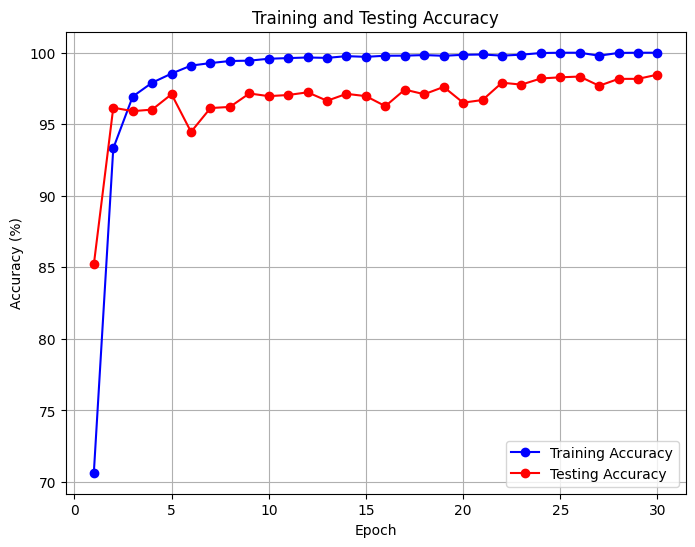

In [57]:
plot_accuracies(train_accuracies, test_accuracies)

# Observations & Explanations

## Observations
- Given enough training epochs, all four models achieve high accuracy.
- Model in Part B learns faster than the one in Part A: Part B reaches approximately 95% test accuracy within the first 5 epochs, while Part A requires about 17 epochs to reach the same level.
- Model in Part C learns at a similar pace as in Part B.
- Model in Part D is the fastest, achieving 95% test accuracy within the first 3 epochs.

## Explanations
- Data augmentation improves the model’s generalization and accelerates learning by exposing it to more varied data. Different shapes, added noise, and speed variations enable the model to recognize the key characteristics and patterns associated with each symbol.
- Using a single type of augmentation—either by applying speech augmentation before converting records to spectrograms or by directly manipulating the spectrograms—results in similar performance.
- Combining two types of data augmentation (speech augmentation followed by spectrum augmentation) leads to faster learning and, overall, better performance.

